<a href="https://colab.research.google.com/github/Remcobdeg/polis_for_HIACT/blob/main/Polis_example_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pol-is/notebooks/blob/master/020-PCA.ipynb)

In [ ]:
### Setting up Google Colab (optional) ###
# Installing necessary packages
!pip install python-igraph
!pip install leidenalg
!pip install umap-learn
# Getting access to Google Drive files (participants-votes.csv etc)
from google.colab import drive
drive.mount("/content/drive")
# Replace with your path in GDrive ->
%cd "/content/drive/My Drive/Colab Notebooks"

### Initialization ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph
import numba
import os

import umap

import igraph as ig
import leidenalg

from sklearn.decomposition import PCA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [ ]:
# ## ONLY RUN ONCE TO DOWNLOAD THE SAMPLE DATA INTO GOOGLE DRIVE ##
# %%bash
# # clone example data from github into google drive
# mkdir -p polis_sample_data
# cd polis_sample_data
# git clone https://github.com/compdemocracy/openData.git

In [ ]:
## Set up plots
plt.figure(figsize=(500, 500))
sns.set_context('poster')
sns.set_style('white')
sns.set(font_scale=.7)
sns.set_color_codes()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

<Figure size 50000x50000 with 0 Axes>

In [ ]:
# choosing a specific dataset to work with
basepath = "/content/drive/My Drive/Colab Notebooks/polis_sample_data/openData/american-assembly.bowling-green/"
os.listdir(basepath)

['comments.csv',
 'participants-votes.csv',
 'stats-history.csv',
 'summary.csv',
 'votes.csv']

### Import raw data && clean up

In [ ]:
# !pwd #print work directory
# !ls #print files in directy -- os.listdir(basepath)
df = pd.read_csv(basepath+'participants-votes.csv',index_col='participant')
df_comments = pd.read_csv(basepath+'comments.csv',index_col='comment-id')

In [ ]:
df_comments.index = df_comments.index.astype(str)

In [ ]:
metadata_fields = ['group-id', 'n-comments', 'n-votes',
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

In [ ]:
# remove statements (columns) which were moderated out
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

In [ ]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`

## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold=60):

    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold

    return df[valid]

df = select_rows(df)

In [ ]:
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")

In [ ]:
high_variance = [
    "20","26","90"
]

vals_high_variance = vals[high_variance]

statements_consensus = [
    "39","200","83","82","737","64","127","126","66",
]

vals_consensus = vals[statements_consensus]

consensus_disagree = [
    "353","779","720","354"
]

vals_consensus_disagree = vals[consensus_disagree]

statements_opiods = [
    "9",
    "19",
    "11",
    "10",
    "675",
    "753",
    "742",
    "336",
    "329",
    "683",
    "686",
    "894",
    "885",
    "846",
    "688",
    "679",
    "678",
    "676",
]
vals_opiods = vals[statements_opiods]


statements_homelessness = [
    "24","25","34",
#     "45",
    "55",
    "103","105","106","147",
    "160","232","233",
    "404",
#     "535",
#     "586",
#     "782",
#     "828",
]
vals_homelessness = vals[statements_homelessness]



vals_all_in = vals[statements_all_in]

# Overall stats

How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [ ]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (1006, 901)
Dimensions of matrix: (1006, 896)
Total number of possible votes: 901376
Total number of agrees: 100041
Total number of disagrees: 35177
Total without vote: 766158
Percent sparse:  0.8499871307867083 %


### Full participants * comments matrix


Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived.

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation.

<Axes: ylabel='participant'>

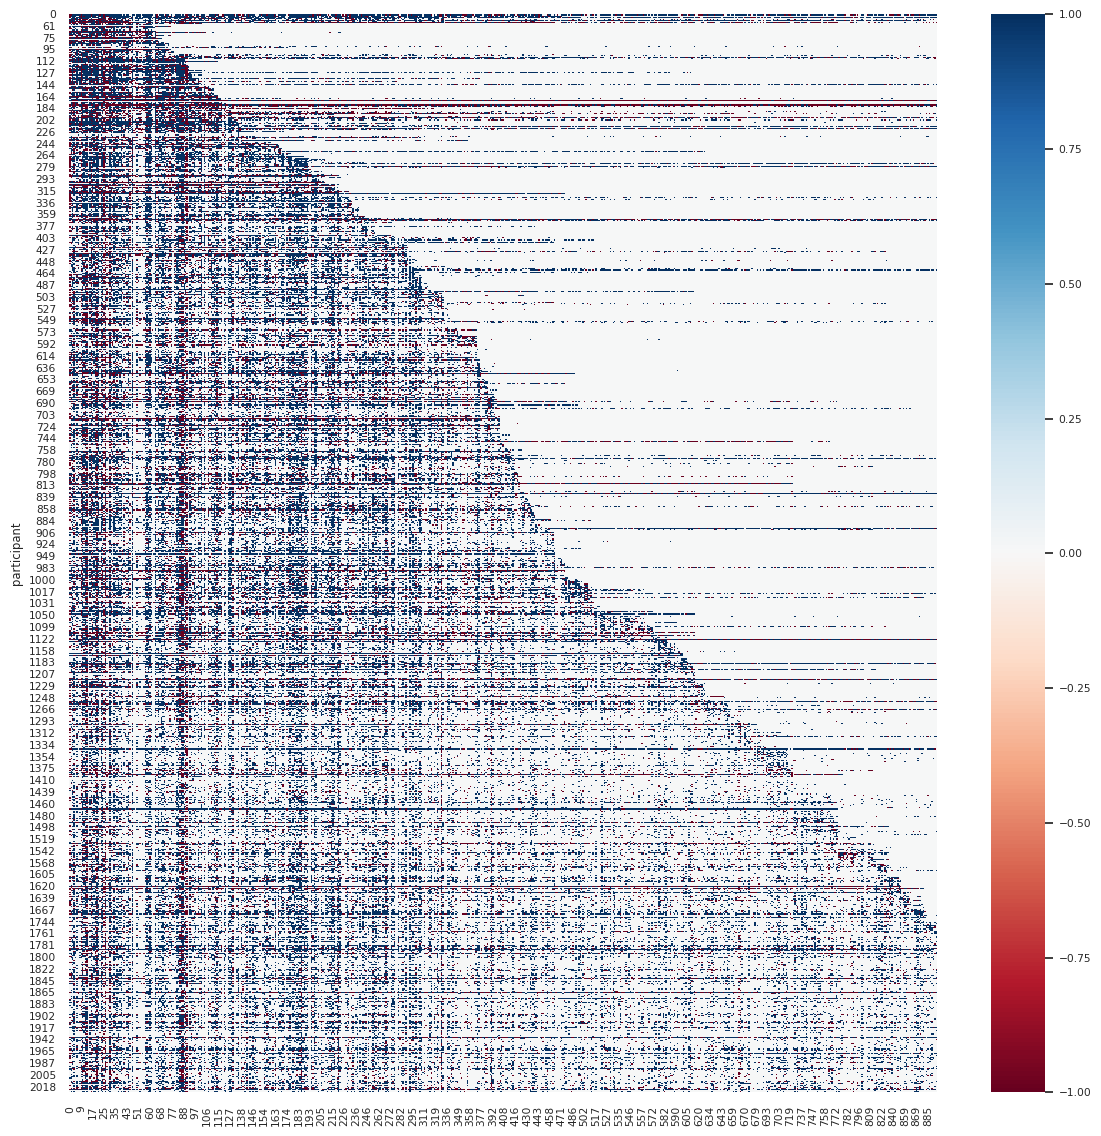

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdBu", ax=ax)

In [ ]:
@numba.njit()
def sparsity_aware_dist(a, b):
    n_both_seen = len(a) - (np.isnan(a) | np.isnan(b)).sum()
    return (n_both_seen - (a == b).sum() + 1) / (n_both_seen + 2)

In [ ]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

In [ ]:
def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric=sparsity_aware_dist,
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=3.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape

    return embedding

In [ ]:
def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    plt.show()

In [ ]:
## Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb

def polis_leiden(dataframe, neighbors):
    A = kneighbors_graph(
        dataframe.values,
        neighbors,
        mode="connectivity",
        metric=sparsity_aware_dist,
        p=3,
        metric_params=None,
        include_self=True,
        n_jobs=None
    )
    print(dataframe.values.shape)
    print(A.shape)

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    part = leidenalg.find_partition(
        g,
        leidenalg.ModularityVertexPartition
    );

    leidenClusters = np.array(part.membership)
    leidenClustersStr = [str(i) for i in leidenClusters]

    from collections import Counter
    print(len(Counter(part.membership).keys()))

    #df["leiden"] = leidenClustersStr

    return leidenClusters

In [ ]:
def polis_subconversation(dataframe, comments):
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    embedding = polis_umap(dataframe, 10)

    leidenClusters = polis_leiden(dataframe, 8)


    # Show clusters given umap embedding
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding[:,0],
        y=embedding[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )
    ax.set_title("Leiden detected communities in UMAP space", fontsize=14)


    # Show clusters given pca embedding
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

    ax.set_title("Leiden detected communities in PCA space", fontsize=14)
    plt.show()

    # number of votes in pca space
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=metadata['n-votes'],
        cmap="magma_r",
        s=5
    )
    plt.colorbar()

    # when did the participant show up? index
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=metadata.index,
        cmap="magma_r",
        s=5
    )
    plt.colorbar()


    # PCA for COMMENTS

    coords, explained_variance = polis_pca(dataframe.T, 2)

    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0],
        y=coords[:,1],
#         c=,
        cmap="magma_r",
        s=5
    )



#     plt.colorbar()

#     # Show clustermap
#     dataframe['leiden_cluster_assignments'] = leidenClusters
#     clusters_by_comments_means = dataframe.groupby('leiden_cluster_assignments').agg('mean')

#     #sns.heatmap(clusters_by_comments_means, cmap="RdYlBu")
#     sns.clustermap(clusters_by_comments_means, cmap="RdYlBu", figsize=(15,15))

    for x in comments:
        c(x, coords)
        c(x, embedding)


In [ ]:
def polis_heatmap(__dataframe):
    leidenClusters = polis_leiden(__dataframe, 8)

    # Show clustermap
    __dataframe['leiden_cluster_assignments'] = leidenClusters
    clusters_by_comments_means = __dataframe.groupby('leiden_cluster_assignments').agg('mean').T

    index_to_label = df_comments['comment-body'].to_dict() # {index: label}

    clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdBu", figsize=(10,10), )

    ax = clustergrid.ax_heatmap
    new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
    ax.set_yticklabels(new_labels, rotation=0, fontsize=10)

### Comparison of k-neighbor and two-layer graph approaches

* Currently a k-neighbor graph of the participant-votes matrix is given as input to the Leiden algorithm for community detection.
* However, the participant-votes matrix can be given directly.
* Quality of results is low, if the adjacency matrix is given as-is, in one-layer format.
    * That is, as a weighted adjacency matrix with 1.0 for positive links, and -1.0 for negative ones.
* Quality of results is comparable to k-neighbors graph, if the two-layer structure is explicitly given as input to the Leiden algorithm.
    * That is, the weighted adjacency matrix is split in two, G_pos and G_neg.
    * G_pos is an unweighted version of the same matrix, with 1.0 where positive links exists and 0.0 otherwise.
    * G_neg is defined similarly for the negative links.
    * Both layers are given as input to Leiden, with layer_weights=[1 -1]
    * (i.e. preferring positive connections and penalizing negative ones.)

* Future work: utilization of bipartite form
    * A bipartite graph can also be expressed in three layers and inputted to the Leiden algo.
    * Together with pos/neg links, makes for a total six layers.
    * A sample implementation can be found below, yet quality is low.


In [ ]:
def generate_pos_neg_graphs(dataframe):
    # Generate two-layer multiplex bipartite graphs using dataframe data
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #
    # Returns:
    #   G_pos: participant-votes bipartite graph of positive votes (i.e. positive layer)
    #   G_neg: participant-votes bipartite graph of negative votes (i.e. negative layer)
    A = dataframe.values

    # Convert 'bipartite' matrix A (rows=participants, columns=votes)
    # into unipartite form, by adding votes rows and participant columns.
    #
    # The new rectangular matrix A_sym can be written in block form as:
    # A_sym = [ 0     A ]
    #         [ A.T   0 ]
    A_sym = np.block([[np.zeros((A.shape[0], A.shape[0])), A], [np.transpose(A), np.zeros((A.shape[1], A.shape[1]))] ])

    # G_pos includes only positive edges (positive weights in A_sym)
    G_pos = ig.Graph.Adjacency((A_sym > 0).tolist(), mode="undirected")
    # G_neg includes only negative edges (negative weights in A_sym)
    G_neg = ig.Graph.Adjacency((A_sym < 0).tolist(), mode="undirected")

    # Partition of nodes in two classes (bipartite graph) - optional info
    # Class 0: participants - first A.shape[0] nodes
    # Class 1: votes - subsequent A.shape[1] nodes
    G_pos.vs['type'] = np.block([np.ones(A.shape[0]), np.zeros(A.shape[1])])
    G_neg.vs['type'] = np.block([np.ones(A.shape[0]), np.zeros(A.shape[1])])

    return G_pos, G_neg

def generate_dual_graph(dataframe):
    # Generate one-layer bipartite graph using dataframe data
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #
    # Returns:
    #   G: participant-votes bipartite graph of pos/neg votes (i.e. one layer)

    A = dataframe.values

    A_sym = np.block([[np.zeros((A.shape[0], A.shape[0])), A], [np.transpose(A), np.zeros((A.shape[1], A.shape[1]))] ])
    g = ig.Graph.Adjacency((A_sym != 0).tolist(), mode="undirected")
    g.es['weight'] = A_sym[A_sym.nonzero()] # Possibly not needed

    # Partition of nodes in two classes (bipartite graph) - optional info
    # Class 0: participants - first A.shape[0] nodes
    # Class 1: votes - subsequent A.shape[1] nodes
    g.vs['type'] = np.block([np.ones(A.shape[0]), np.zeros(A.shape[1])])

    # Naming nodes for easy retrieval
    for idx, v in enumerate(g.vs):
      v['name'] = idx

    return g

In [ ]:
def generate_kneighbors_graph(dataframe, neighbors):
    # Generate k-neighbors unipartite graphs using dataframe data
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #   neighbors (int): number of neighbors (k)
    #
    # Returns:
    #   G: participant-participant unipartite graph of k-neighbors connectivity

    A = kneighbors_graph(
        dataframe.values,
        neighbors,
        mode="connectivity",
        metric=sparsity_aware_dist,
        p=3,
        metric_params=None,
        include_self=True,
        n_jobs=None
    )
    print("Dataframe shape: {}".format(dataframe.values.shape))
    print("Kneighbor graph shape: {}".format(A.shape))

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    return g

#generate_kneighbors_graph(vals_all_in, 8)

In [ ]:
def polis_leiden_onelayer(graph, optimizationfunction):
    # Calculate clusters using Leiden algorithm for one-layer graph
    #
    # Parameters:
    #   graph: the graph to detect communities on
    #   optimizationfunction: the optimization function for Leiden alg
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    part = leidenalg.find_partition(
        graph,
        optimizationfunction
    );

    leidenClusters = np.array(part.membership)

    # Print total nr of communities detected
    from collections import Counter
    print("Nr of communities detected: {}".format(len(Counter(part.membership).keys())))

    return leidenClusters

def polis_leiden_onelayer_iterative(graph, optimizationfunction, n_iterations):
    # Calculate clusters using Leiden algorithm for one-layer graph, iteratively
    #
    # Parameters:
    #   graph: the graph to detect communities on
    #   optimizationfunction: the optimization function for Leiden alg
    #   n_iterations (int): number of iterations
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    part = optimizationfunction(graph)
    diff = leidenalg.Optimiser().optimise_partition(part, n_iterations)

    leidenClusters = np.array(part.membership)

    # Print total nr of communities detected
    from collections import Counter
    print("Nr of communities detected after {} iterations: {}".format(
        n_iterations,
        len(Counter(part.membership).keys())))

    return leidenClusters

In [ ]:
def polis_leiden_twolayers(G_pos, G_neg, optimizationfunction):
    # Calculate clusters using Leiden algorithm for two-layer graph
    #
    # Parameters:
    #   G_pos: the positive (layer of the) graph
    #   G_neg: the negative (layer of the) graph
    #   optimizationfunction: the optimization function for Leiden alg
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    optimiser = leidenalg.Optimiser()
    partition_pos = optimizationfunction(G_pos)
    partition_neg = optimizationfunction(G_neg)
    # Both layers are fed into Leiden. layer_weights=[1,-1] penalize negative layer
    # See also 4.1.1 in https://readthedocs.org/projects/leidenalg/downloads/pdf/latest/
    diff = optimiser.optimise_partition_multiplex(
                   partitions=[partition_pos, partition_neg],
                   layer_weights=[1,-1])

    leidenClusters = np.array(partition_pos.membership)

    # Print the sequence and nr of communities detected
    from collections import Counter
    print("Nr of communities detected: {}".format(len(Counter(partition_pos.membership).keys())))
    print("Seq of communities detected: {}".format(Counter(np.array(partition_pos.membership))))

    return leidenClusters
'''
from collections import Counter
G_pos, G_neg = generate_pos_neg_graphs(vals_all_in)
lc = polis_leiden_twolayers(G_pos, G_neg, leidenalg.ModularityVertexPartition)
lc_participants = lc[:vals_all_in.shape[0]]
'''
def polis_leiden_twolayers_iterative(G_pos, G_neg, optimizationfunction, n_iterations):
    # Calculate clusters using Leiden algorithm for two-layer graph, iterative
    #
    # Parameters:
    #   G_pos: the positive (layer of the) graph
    #   G_neg: the negative (layer of the) graph
    #   optimizationfunction: the optimization function for Leiden alg
    #   n_iterations (int): number of iterations
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    optimiser = leidenalg.Optimiser()
    partition_pos = optimizationfunction(G_pos)
    partition_neg = optimizationfunction(G_neg)
    diff = optimiser.optimise_partition_multiplex(
                   partitions=[partition_pos, partition_neg],
                   layer_weights=[1,-1],
                   n_iterations=n_iterations)

    leidenClusters = np.array(partition_pos.membership)

    # Print the sequence and nr of communities detected
    from collections import Counter
    print("Nr of communities detected after {} iterations: {}".format(
        n_iterations,
        len(Counter(partition_pos.membership).keys())))
    print("Seq of communities detectedafter {} iterations: {}".format(
        n_iterations,
        Counter(np.array(partition_pos.membership))))

    return leidenClusters

In [ ]:
def polis_leiden_twolayers_bipartite(G_pos, G_neg):
    # DO NOT USE! Currently not working as intended!
    #
    # Calculate clusters using Leiden algorithm for two-layer bipartite graph
    #
    # NB: Unlike the other polis_leiden_* functions, this always optimizes using modularity
    #
    # Parameters:
    #   G_pos: the positive (layer of the) graph
    #   G_neg: the negative (layer of the) graph
    #
    # Returns:
    #   leidenClusters: the partition sequence detected by Leiden alg

    optimiser = leidenalg.Optimiser()
    part_pos_0, part_pos_1, part_pos_2 = leidenalg.CPMVertexPartition.Bipartite(G_pos, 0.01, 0, 0, True);
    part_neg_0, part_neg_1, part_neg_2 = leidenalg.CPMVertexPartition.Bipartite(G_neg, 0.01, 0, 0, True);
    # See also https://leidenalg.readthedocs.io/en/stable/reference.html#leidenalg.CPMVertexPartition.Bipartite
    diff = optimiser.optimise_partition_multiplex(
        partitions=[part_pos_0, part_pos_1, part_pos_2, part_neg_0, part_neg_1, part_neg_2],
        layer_weights=[1,-1,-1,-1,-1,-1]
        )

    leidenClusters = np.array(part_pos_0.membership)

    # Print the sequence and nr of communities detected
    from collections import Counter
    print("Nr of communities detected: {}".format(len(Counter(part_pos_0.membership).keys())))
    print("Seq of communities detected: {}".format(Counter(np.array(part_pos_0.membership))))

    return leidenClusters

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1850: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


Explained variance: [0.12267305 0.06782146]
Dataframe shape: (1006, 607)
Kneighbor graph shape: (1006, 1006)
Nr of communities detected: 7


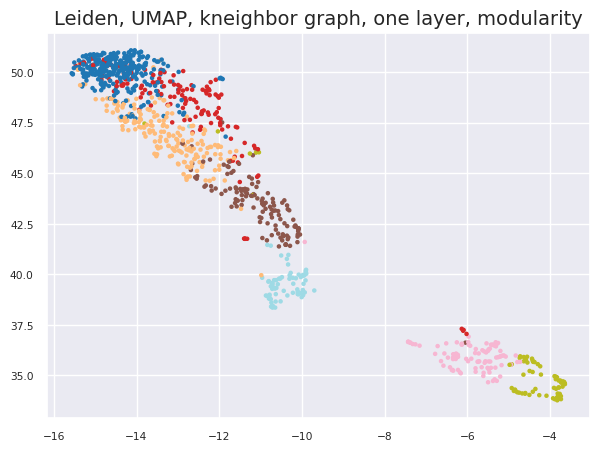

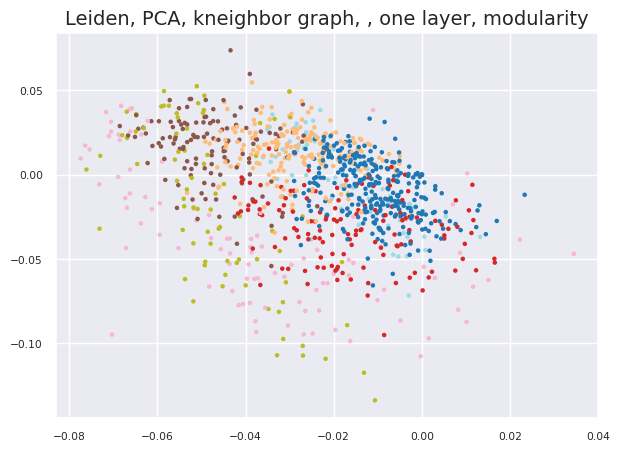

Nr of communities detected: 10


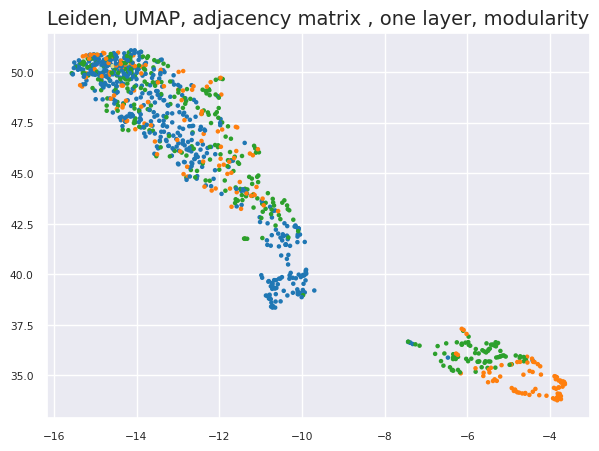

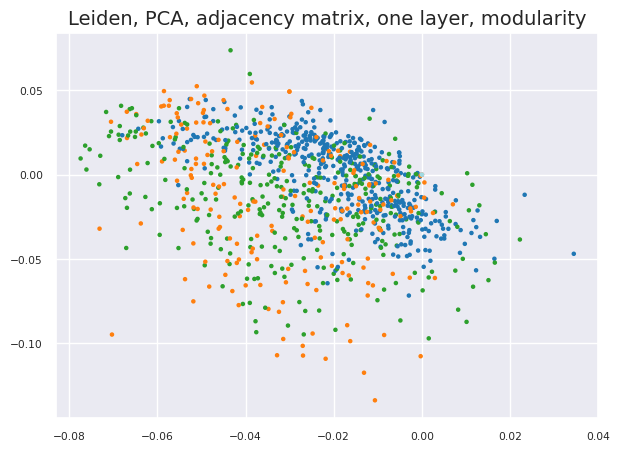

Nr of communities detected: 12
Seq of communities detected: Counter({0: 821, 1: 660, 2: 123, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1})


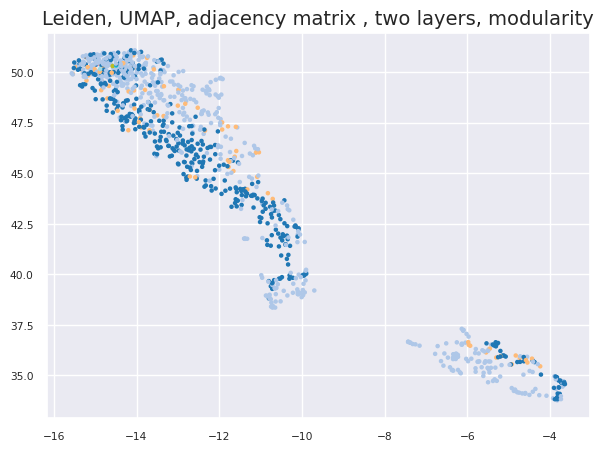

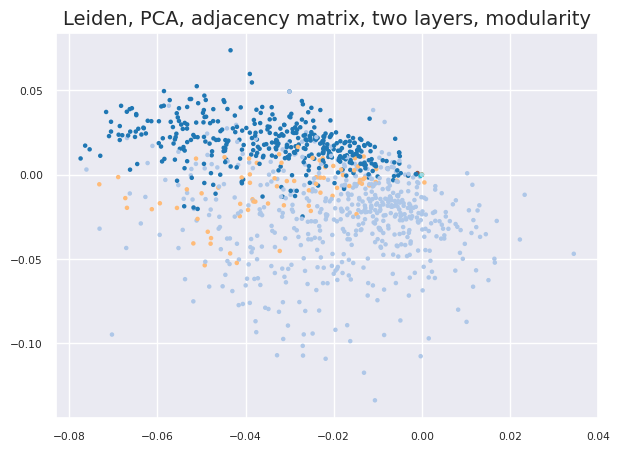

In [ ]:
def show_embedding(space, color, title):
    # Helper function to plot community data as color on an embedding space
    #
    # Parameters:
    #   space: the embedding space to plot data on (e.g. UMAP, PCA)
    #   color: the community data to plot as color in the embedding
    #   title: the plot's title

    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    # NB: palette contains only 20 colors ('tab20')
    # (User needs to artificially limit communities to <20)
    ax.scatter(
        x=space[:,0],
        y=space[:,1],
        c=color,
        cmap="tab20",
        s=5
    )
    ax.set_title(title, fontsize=14)
    plt.show()

def polis_subconversation_alt(dataframe, comments):
    # Experimentation with and plotting of different community detection
    # scenarios, on variations of the same dataset.
    #
    # (Approximate stand-in for original polis_subconversation function)
    #
    # Parameters:
    #   dataframe: a participant-votes dataframe
    #   comments: not used here

    embedding = polis_umap(dataframe, 10)
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    #leidenClusters = polis_leiden(dataframe, 8)
    #show_embedding(embedding, leidenClusters, "Leiden detected communities in UMAP space")
    #show_embedding(coords, leidenClusters, "Leiden detected communities in PCA space")

    ########################
    # K-neighbors, one layer
    ########################
    G_kneighbors = generate_kneighbors_graph(dataframe, 8)
    lc = polis_leiden_onelayer(G_kneighbors, leidenalg.ModularityVertexPartition)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, modularity")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, , one layer, modularity")

    '''
    lc = polis_leiden_onelayer_iterative(G_kneighbors, leidenalg.ModularityVertexPartition, 10)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, modularity, iterative")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, , one layer, modularity, iterative")

    lc = polis_leiden_onelayer(G_kneighbors, leidenalg.CPMVertexPartition)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, CPM")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, one layer, CPM")

    lc = polis_leiden_onelayer_iterative(G_kneighbors, leidenalg.CPMVertexPartition, 10)
    show_embedding(embedding, lc, "Leiden, UMAP, kneighbor graph, one layer, CPM, iterative")
    show_embedding(coords, lc, "Leiden, PCA, kneighbor graph, one layer, CPM, iterative")
    '''

    #############################
    # Adjacency matrix, one layer
    #############################
    G = generate_dual_graph(dataframe)
    lc = polis_leiden_onelayer(G, leidenalg.ModularityVertexPartition)
    # Adjustment in case of > 20 communities (i.e. limited color palette)
    lc_show = []
    for x in lc[:embedding.shape[0]]:
      lc_show.append(x) if x < 20 else lc_show.append(20)
    show_embedding(embedding, lc_show, "Leiden, UMAP, adjacency matrix , one layer, modularity")
    show_embedding(coords, lc_show, "Leiden, PCA, adjacency matrix, one layer, modularity")

    '''
    lc = polis_leiden_onelayer_iterative(G, leidenalg.ModularityVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, one layer, modularity, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, one layer, modularity, iterative")

    lc = polis_leiden_onelayer(G, leidenalg.CPMVertexPartition)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, one layer, CPM")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, one layer, CPM")

    lc = polis_leiden_onelayer_iterative(G, leidenalg.CPMVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, one layer, CPM, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, one layer, CPM, iterative")
    '''

    ##############################
    # Adjacency matrix, two layers
    ##############################
    G_pos, G_neg = generate_pos_neg_graphs(dataframe)
    lc = polis_leiden_twolayers(G_pos, G_neg, leidenalg.ModularityVertexPartition)
    # Adjustment in case of > 20 communities (i.e. limited color pallete)
    lc_show = []
    for x in lc[:embedding.shape[0]]:
      lc_show.append(x) if x < 20 else lc_show.append(20)
    show_embedding(embedding, lc_show, "Leiden, UMAP, adjacency matrix , two layers, modularity")
    show_embedding(coords, lc_show, "Leiden, PCA, adjacency matrix, two layers, modularity")
    '''
    lc = polis_leiden_twolayers_iterative(G_pos, G_neg, leidenalg.ModularityVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, two layers, modularity, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, two layers, modularity, iterative")

    lc = polis_leiden_twolayers(G_pos, G_neg, leidenalg.CPMVertexPartition)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, two layers, CPM")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, two layers, CPM")

    lc = polis_leiden_twolayers_iterative(G_pos, G_neg, leidenalg.CPMVertexPartition, 10)
    show_embedding(embedding, lc[:embedding.shape[0]], "Leiden, UMAP, adjacency matrix, two layers, CPM, iterative")
    show_embedding(coords, lc[:coords.shape[0]], "Leiden, PCA, adjacency matrix, two layers, CPM, iterative")
    '''

    #########################################
    # Adjacency matrix, two layers, bipartite
    #########################################
    '''
    G_pos, G_neg = generate_pos_neg_graphs(dataframe)
    lc = polis_leiden_twolayers_bipartite(G_pos, G_neg)
    # Adjustment in case of > 20 communities (i.e. limited color palette)
    lc_show = []
    for x in lc[:embedding.shape[0]]:
      lc_show.append(x) if x < 20 else lc_show.append(20)
    show_embedding(embedding, lc_show, "Leiden, UMAP, adjacency matrix , two layers, modularity, bipartite")
    show_embedding(coords, lc_show, "Leiden, PCA, adjacency matrix, two layers, modularity, bipartite")
    '''

    return lc, G

leidenClust, G = polis_subconversation_alt(vals_all_in, high_variance)

## Looking into comments:

* which communities they belong to, according to the last Leiden run above

In [ ]:
index_to_label = df_comments['comment-body'].to_dict() # {index: label}
print(index_to_label)
print(leidenClust)
from collections import Counter
print("Nr of comments/statements belonging to communities: {}".format(Counter(leidenClust[1006:])))

statements_indx = [index_to_label[str(v["name"]-1006)] for v in G.vs if v["type"] == 0.0]
statements = [v["name"] for v in G.vs if v["type"] == 0.0]
#import pprint
#pprint.pprint(sorted(zip(leidenClust[statements],statements_indx)))


{'895': 'Smallhouse Rd (at Campbell Ln) heading into town needs to be widened to have room for three lanes (left turn, straight, right turn).', '894': "Doctors should not overreact to the opioid crisis. People in pain shouldn't suffer because others lack self control and abuse the system.", '893': 'More free meeting space for nonprofits.', '892': 'Skating rink on Gordon ave.', '891': 'After school activity centers for youth with later hours of operation.', '890': 'More affordable home ownership options.', '889': 'We need to build up and support the historic downtown.   There needs to be less apartments and more activities that support the community.', '888': 'Better visibility on roads. Reflectors and better signage', '887': 'Free cookies for everyone! Yay!', '886': 'Legalize marijuana so people will stop talking about legalizing marijuana.', '885': 'The main problem facing is the workforce development. There is over 6500 jobs open in Warren County. This is a big issue.', '884': 'Under

# Is the space explained by how much people vote?

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial.
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:
* polis eliminates participants who don't vote at least 7 times from the analysis
* polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

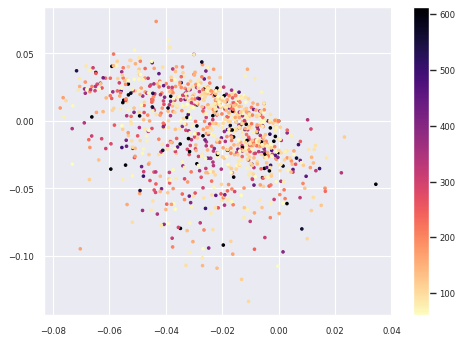

In [ ]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0],
    y=coords[:,1],
    c=metadata['n-votes'],
    cmap="magma_r",
    s=5
)
plt.colorbar()

# High Variance

Explained variance: [0.12267305 0.06782146]


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1850: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


(1006, 607)
(1006, 1006)
8


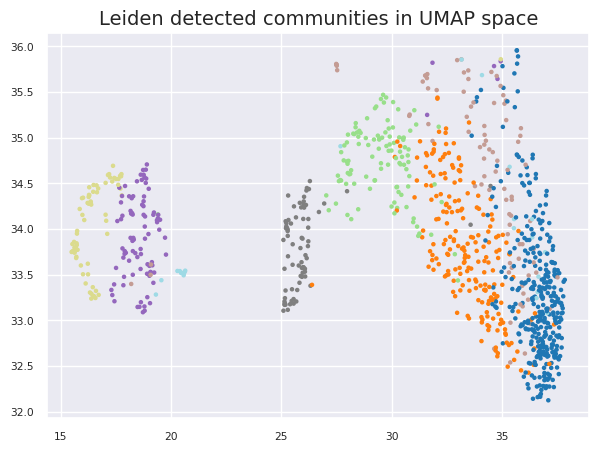

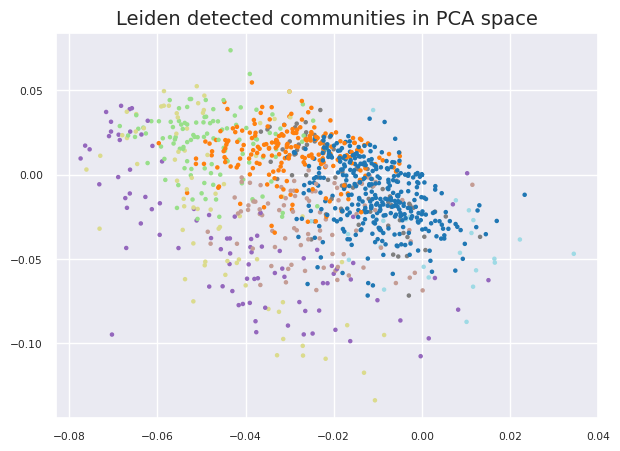

<ipython-input-21-71c555327461>:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


ValueError: 'c' argument has 1006 elements, which is inconsistent with 'x' and 'y' with size 607.

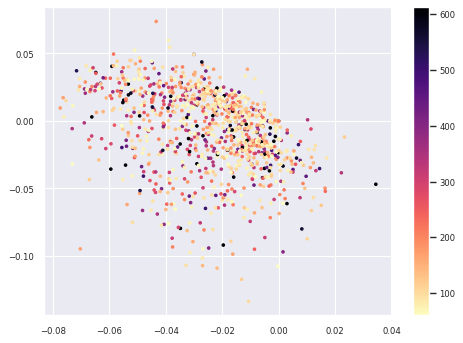

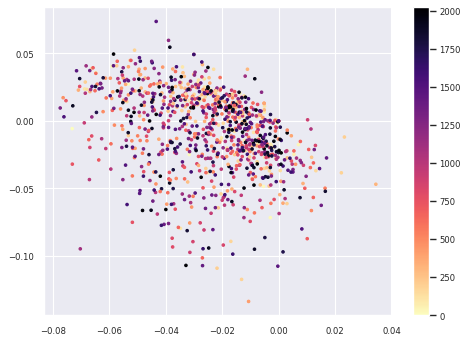

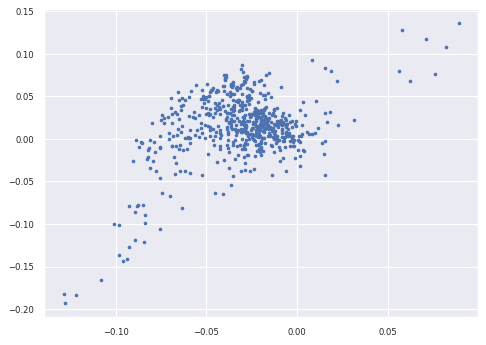

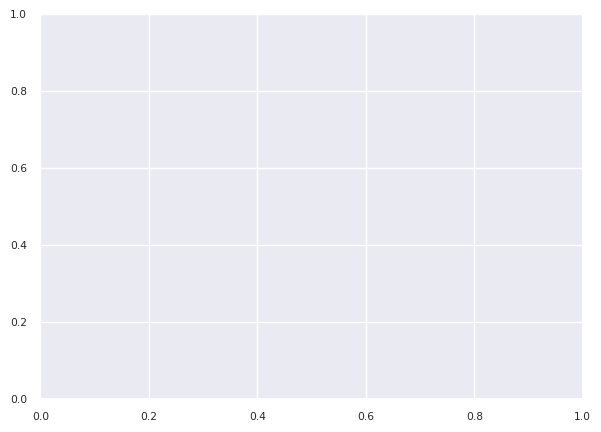

In [ ]:
polis_subconversation(vals_all_in, high_variance)

# Consensus

In [ ]:
polis_subconversation(vals_all_in, statements_consensus)

# Opiods

In [ ]:
polis_heatmap(vals_opiods)

In [ ]:
polis_subconversation_alt(vals_opiods, statements_opiods)

# Homelessness

In [ ]:
leidenClusters = polis_leiden(__dataframe, 8)

# Show clustermap
__dataframe['leiden_cluster_assignments'] = leidenClusters

index_to_label = df_comments['comment-body'].to_dict() # {index: label}

clustergrid = sns.clustermap(vals_homelessness, cmap="RdBu", figsize=(10,10), )

ax = clustergrid.ax_heatmap
new_labels = [index_to_label[str(idx._text)] for idx in ax.get_xticklabels()] # [ label0, label1, label2, ...]
ax.set_xticklabels(new_labels, rotation=90, fontsize=10)

In [ ]:
polis_heatmap(vals_homelessness)

In [ ]:
polis_subconversation(vals_homelessness, statements_homelessness)

# All

In [ ]:
# coords, explained_variance = polis_pca(vals_all_in, 2)
# print("Explained variance:", explained_variance)

# embedding = polis_umap(vals_all_in, 4)

# leidenClusters = polis_leiden(vals_all_in, 8)

# # Show clusters given umap embedding
# fig, ax = plt.subplots(figsize=(7,5))
# plt.sca(ax)
# ax.scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     c=leidenClusters,
#     cmap="tab20",
#     s=5
# )

# ax.set_title("Leiden detected communities in UMAP space", fontsize=14)
# plt.show()

# for x in statements_all_in:
#     if int(x) < 5:
#         c(x, coords)
#         c(x, embedding)

In [ ]:
# leidenClusters = polis_leiden(vals_opiods, 8)

# # Show clustermap
# vals_opiods['leiden_cluster_assignments'] = leidenClusters
# clusters_by_comments_means = vals_opiods.groupby('leiden_cluster_assignments').agg('mean').T

In [ ]:
# index_to_label = df_comments['comment-body'].to_dict() # {index: label}

# clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdYlBu", figsize=(15,15), )

# ax = clustergrid.ax_heatmap
# new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
# ax.set_yticklabels(new_labels, rotation=0, fontsize=16)